# Spectral Bias Analysis of Cavity 



In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import sys
import torch
import gc
from matplotlib import pyplot as plt

Import local packages

In [5]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils.logger import Logging
from src.utils.color import model_color
from src.utils.plot_spectral import plot_spectral

Set various constant variables: model path, name, etc. We choose the best performing models from each architecture.

## Create Logger for saving Results

In [ ]:
TEST_CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, "result/fsi")
logger = Logging(TEST_CHECKPOINT_PATH)
result_dir = logger.get_output_dir()

In [50]:
TEST_DATA_PKL = "../../data/IB_PINN3.mat"
TEST_CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, "result/fsi")

RBA = "/home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-15_18-41-49-625964/model.pth"  # "/home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-15_17-36-49-818397/model.pth"
FIXED_WEIGHT = "/home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-15_18-41-39-771272/model.pth"  # "/home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-15_17-11-45-691256/model.pth"
SA = "/home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-15_18-42-12-444785/model.pth"  # "/home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-15_17-37-33-081291/model.pth"
Grad_stat = "/home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-15_18-41-55-608353/model.pth"  # "/home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-15_17-37-23-782676/model.pth"
MODEL_PATH_LIST = {
    "RBA": RBA,
    "Fixed": FIXED_WEIGHT,
    "SA": SA,
    "grad_stat": Grad_stat,
}


SOLVER_TO_MODULE = {
    "tanh": "src.nn.tanh",
    "xsig": "src.nn.xsigmoid",
}

## Load the saved models 

In [53]:
max_eig_hessian_bc_log_dic = {}
max_eig_hessian_res_log_dic = {}
max_eig_hessian_ic_log_dic = {}

for model_name, model_path in MODEL_PATH_LIST.items():
    logger.print(f"MODEL_PATH {model_path}")
    # Load the state from the saved model
    state = torch.load(
        model_path,
    )
    config = state.get("config", {})
    solver = config.get("solver")
    max_eig_hessian_bc_log = state.get("max_eig_hessian_bc_log")
    max_eig_hessian_ic_log = state.get("max_eig_hessian_ic_log")
    max_eig_hessian_res_log = state.get("max_eig_hessian_res_log")
    # Extract model configuration from state
    model_activation_name = config.get("activation")
    model_architecture = config.get("network")
    loss_dict = state.get("loss_history")

    logger.print(f"activation:  , {model_activation_name}")
    logger.print(f"problem: {config.get('problem')}")
    logger.print(f"solver:  , {solver}")
    logger.print(f"network:  , {config.get('network')}")
    logger.print(f"term loss weights :  , {config.get('weights')}")

    # logger.print(
    #     f"Model {model_name} with iterations: {len(loss_dict[next(iter(loss_dict))])}"
    # )

    max_eig_hessian_bc_log_dic[model_name] = max_eig_hessian_bc_log
    max_eig_hessian_res_log_dic[model_name] = max_eig_hessian_res_log
    max_eig_hessian_ic_log_dic[model_name] = max_eig_hessian_ic_log

    logger.print("******************************\n")
    gc.collect()
    torch.cuda.empty_cache()

logger.print("file directory:", logger.get_output_dir())

INFO:src.utils.logger:MODEL_PATH /home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-15_18-41-49-625964/model.pth


INFO:src.utils.logger:activation:  , xsig
INFO:src.utils.logger:problem: fsi
INFO:src.utils.logger:solver:  , xsig
INFO:src.utils.logger:network:  , [3, 200, 200, 200, 200, 5]
INFO:src.utils.logger:term loss weights :  , None
INFO:src.utils.logger:******************************

INFO:src.utils.logger:MODEL_PATH /home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-15_18-41-39-771272/model.pth
INFO:src.utils.logger:activation:  , xsig
INFO:src.utils.logger:problem: fsi
INFO:src.utils.logger:solver:  , xsig
INFO:src.utils.logger:network:  , [3, 200, 200, 200, 200, 5]
INFO:src.utils.logger:term loss weights :  , None
INFO:src.utils.logger:******************************

INFO:src.utils.logger:MODEL_PATH /home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-15_18-42-12-444785/model.pth
INFO:src.utils.logger:activation:  , xsig
INFO:src.utils.logger:problem: fsi
INFO:src.utils.logger:solver:  , xsig
INFO:src.utils.logger:network:  , [3, 200, 200, 200, 200, 5]
INFO:src.utils.log

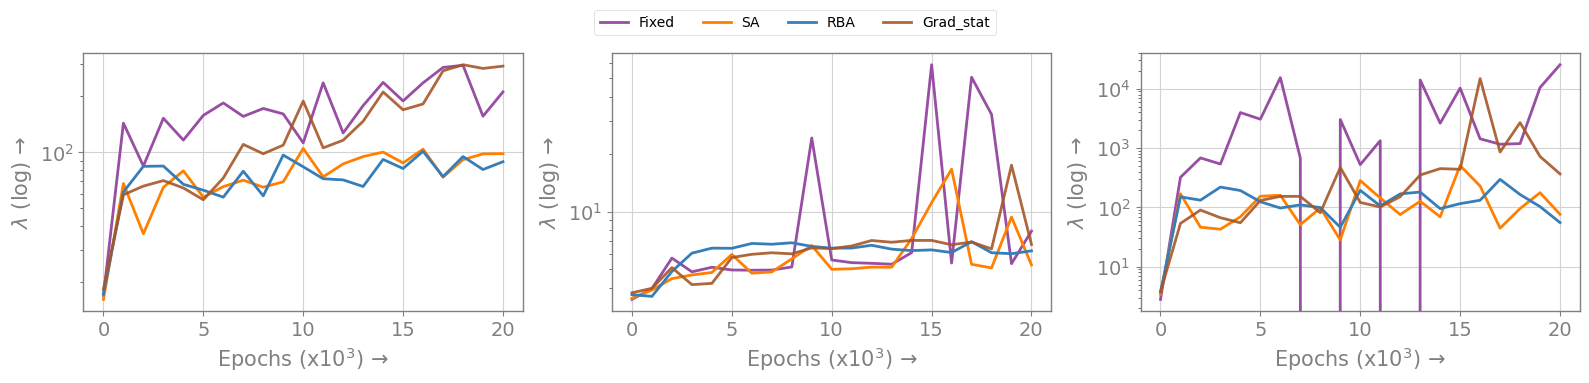

In [54]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches([16, 3.5])  # Adjusted figure size
dict_list = [
    max_eig_hessian_bc_log_dic,
    max_eig_hessian_ic_log_dic,
    max_eig_hessian_res_log_dic,
]
lines = []  # List to collect Line2D objects for the legend
labels = []  # List to collect corresponding labels

for index in range(len(dict_list)):
    data_list = [
        {
            "data": dict_list[index]["Fixed"],
            "color": model_color["tanh"],
            "name": "Fixed",
            "alpha": 1.0,
        },
        {
            "data": dict_list[index]["SA"],
            "color": model_color["param_tanh"],
            "name": "SA",
            "alpha": 1.0,
        },
        {
            "data": dict_list[index]["RBA"],
            "color": model_color["bspline"],
            "name": "RBA",
            "alpha": 1.0,
        },
        {
            "data": dict_list[index]["grad_stat"],
            "color": model_color["grbf"],
            "name": "Grad_stat",
            "alpha": 0.9,
            "window": 100,
            "show_avg": False,
            "show_lower": False,
        },
    ]

    # Call the plot_spectral function, assuming it does the plotting
    plot_spectral(ax[index], data_list)

# Extract line objects from the current axis for the legend
for line in ax[-1].get_lines():
    lines.append(line)
    labels.append(line.get_label())

# Save the figure
save_path = os.path.join(logger.get_output_dir(), "spectral_cavity.png")

# Create a single legend from the collected lines and labels
legend = fig.legend(
    lines, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=7
)
legend.get_frame().set_facecolor("white")

plt.tight_layout()
plt.savefig(save_path)